## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf

import quantstats as qs

from src.env.env import CustomStockEnv
import warnings

warnings.simplefilter(action='ignore')

## Constants

In [2]:
INITIAL_INVESTMENT = 30_000
NUMBER_OF_EPISODES = 10_000

## Extract historical data

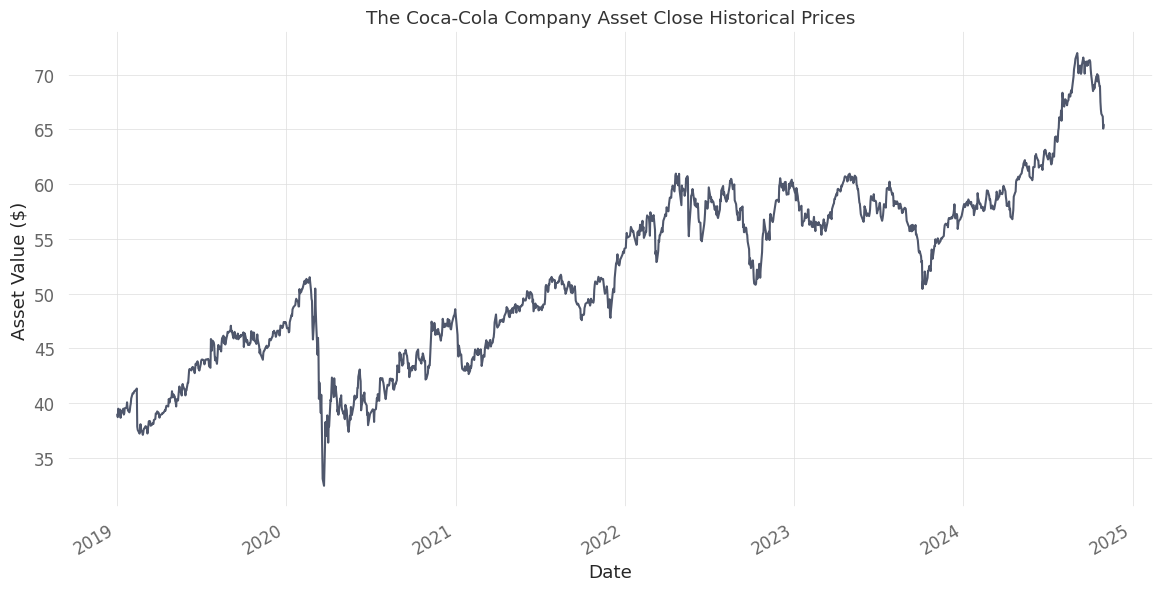

In [3]:
env = CustomStockEnv.build_from_symbol('2019-01-01', '2024-10-31')
data = env.data

data['Close'].plot(figsize=(14, 7), title='The Coca-Cola Company Asset Close Historical Prices', ylabel='Asset Value ($)', xlabel='Date', color=plt.cm.cividis(0.3))
plt.show()

## Calculate returns, expected mean returns and risk

In [4]:
## get the returns
returns = data.pct_change()

## calculate the expected mean returns
mean_return = returns.mean()

## calculate the asset trading risk
volatility = returns.std()

print(f"Mean Return: {round(mean_return['Close'], 5)}")
print(f"Volatility (Risk): {round(volatility['Close'], 5)}")

Mean Return: 0.00044
Volatility (Risk): 0.01283


## Define statistical strategy

### MACD Strategy

In [5]:
from src.utils.macd_strategy import MACDStrategy

strategy = MACDStrategy(CustomStockEnv.build_from_symbol(start_date="2019-01-01", end_date="2024-10-31"))
strategy.apply_strategy(INITIAL_INVESTMENT)
data = strategy.data

## Strategy results

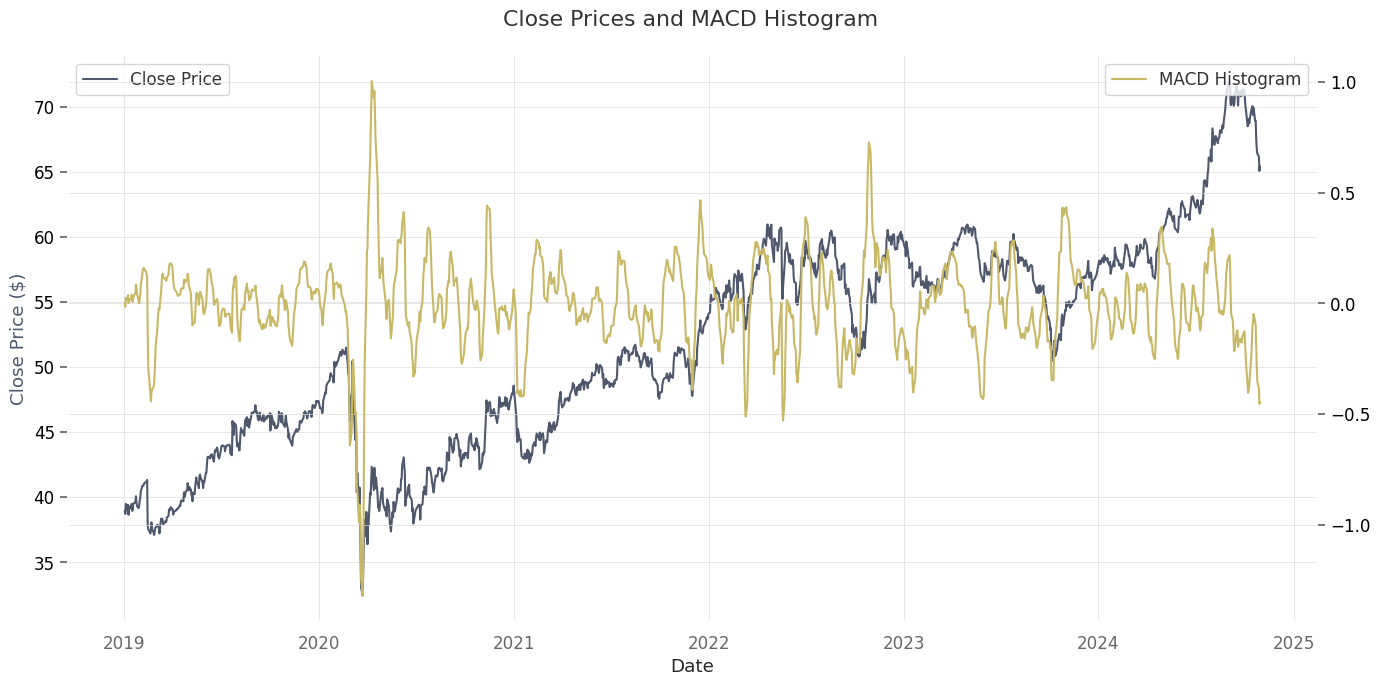

In [6]:
color1 = plt.cm.cividis(0.3)
color2 = plt.cm.cividis(0.8)

fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot the close prices
ax1.plot(data.index, data['Close'], label='Close Price', color=color1)
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price ($)', color=color1)
ax1.tick_params(axis='y', labelcolor='black')

# Create a second y-axis to plot the histogram
ax2 = ax1.twinx()
ax2.plot(data.index, data['Histogram'], label='MACD Histogram', color=color2)
ax2.tick_params(axis='y', labelcolor='black')

fig.suptitle('Close Prices and MACD Histogram')
ax1.legend()
ax2.legend()
fig.tight_layout()
plt.show()

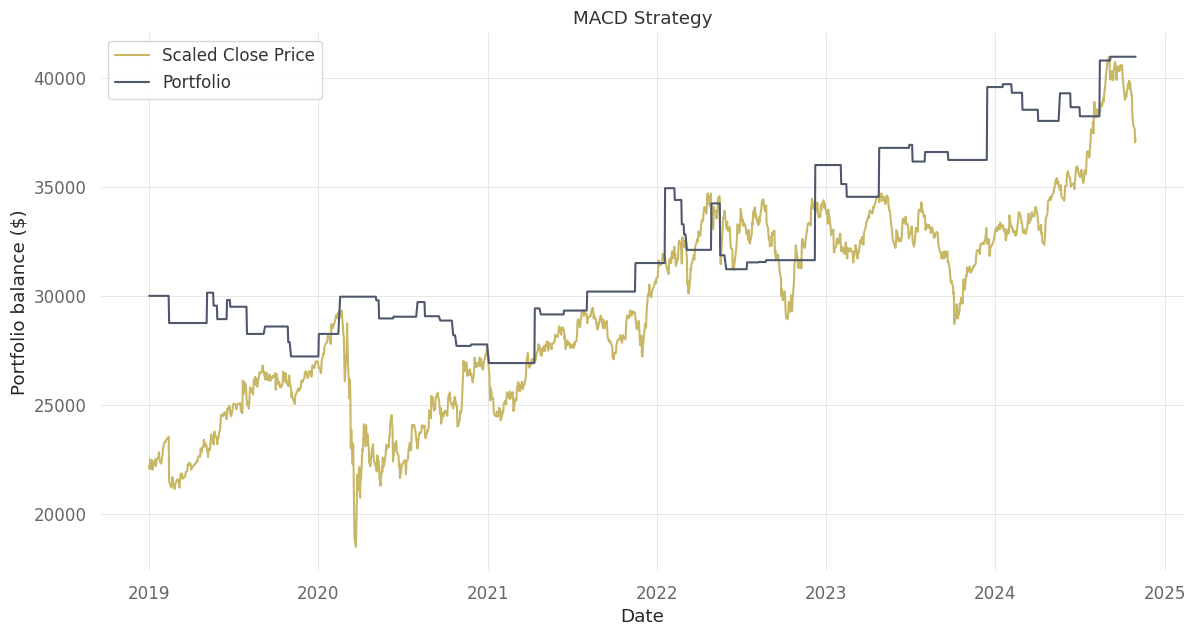

In [7]:
scaled_close = data['Close'] * (data['Portfolio'].max() / data['Close'].max())

# Plot the portfolio results with cividis color map
plt.figure(figsize=(14, 7))
plt.plot(data.index, scaled_close, label='Scaled Close Price', color=plt.cm.cividis(0.8))
plt.plot(data.index, data['Portfolio'], label='Portfolio', color=plt.cm.cividis(0.3))
plt.legend()
plt.title('MACD Strategy')
plt.xlabel('Date')
plt.ylabel('Portfolio balance ($)')
plt.show()

In [8]:
from src.utils.backtest import Backtest

Backtest.evaluate(strategy, initial_investment=INITIAL_INVESTMENT)

,Metric,Value
0,Annual Returns,9.31%
1,Cumulative Returns,167.94%
2,Volatility (Risk),20.36%
3,Sharpe Ratio,0.39
4,CAGR,9.31%
5,Variance,4.15%
6,Initial Investment,30000.00
7,Final Investment Product,50380.83


## Agent

### Q-Learning agent

In [9]:
from src.agent.q_learning_agent import QLearningAgent

agent = QLearningAgent(
        env=env,
        entry_points=strategy.entry_points,
        symbol_risk_free_rate=strategy.risk)

total_reward, portfolio, trades = agent.learn(initial_investment=INITIAL_INVESTMENT, num_episodes=NUMBER_OF_EPISODES, verbose=True)

Episode 1 of 10000 finished.
Episode 500 of 10000 finished.
Episode 1000 of 10000 finished.
Episode 1500 of 10000 finished.
Episode 2000 of 10000 finished.
Episode 2500 of 10000 finished.
Episode 3000 of 10000 finished.
Episode 3500 of 10000 finished.
Episode 4000 of 10000 finished.
Episode 4500 of 10000 finished.
Episode 5000 of 10000 finished.
Episode 5500 of 10000 finished.
Episode 6000 of 10000 finished.
Episode 6500 of 10000 finished.
Episode 7000 of 10000 finished.
Episode 7500 of 10000 finished.
Episode 8000 of 10000 finished.
Episode 8500 of 10000 finished.
Episode 9000 of 10000 finished.
Episode 9500 of 10000 finished.
Episode 10000 of 10000 finished.


## Agent Results

In [10]:
Backtest.model_evaluation(portfolio)

,Metric,Value
0,Annual Returns,-6.42%
1,Cumulative Returns,67.93%
2,Volatility (Risk),20.34%
3,Sharpe Ratio,0.54
4,CAGR,9.31%
5,Variance,0.02%
6,Initial Investment,30000.00
7,Final Investment Product,50379.00


### Model fine-tuning

In [11]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

from src.env.q_learning_tuning_env import QLearningTuningEnv

# Create the meta-environment
meta_env = DummyVecEnv([lambda: QLearningTuningEnv(strategy=strategy, max_episodes=5)])

# Create and train the PPO agent
ppo_agent = PPO(
    "MlpPolicy",
    meta_env,
    n_steps=256,      # Reduced rollout length to prevent memory issues
    verbose=0
)
ppo_agent.learn(total_timesteps=50)

# Get the best hyperparameters from the trained PPO agent
obs = meta_env.envs[0].observation_space.sample()
action, _ = ppo_agent.predict(obs, deterministic=True)

# Extract hyperparameters using the action index
best_hyperparameters = meta_env.envs[0].action_combinations[action]
alpha, gamma, epsilon_min, epsilon_decay, lambda_min, lambda_decay = best_hyperparameters

print("Best Hyperparameters Found:")
print(f"Learning Rate: {round(alpha, 2)}, Gamma: {round(gamma, 2)}, Minimum Epsilon: {round(epsilon_min, 2)}, Epsilon Decay: {round(epsilon_decay, 3)}, Minimun Lambda: {round(lambda_min, 2)}, Lambda Decay: {round(lambda_decay, 3)}")

Episode: 1/5, Learning Rate: 0.34, Gamma: 0.2, Minimum Epsilon: 0.2, Epsilon Decay: 0.999, Minimun Lambda: 0.69, Lambda Decay: 0.45
Episode: 2/5, Learning Rate: 0.88, Gamma: 0.3, Minimum Epsilon: 0.2, Epsilon Decay: 0.45, Minimun Lambda: 0.89, Lambda Decay: 0.889
Episode: 3/5, Learning Rate: 0.45, Gamma: 0.1, Minimum Epsilon: 0.2, Epsilon Decay: 0.01, Minimun Lambda: 0.99, Lambda Decay: 0.12
Episode: 4/5, Learning Rate: 0.99, Gamma: 0.89, Minimum Epsilon: 0.79, Epsilon Decay: 0.669, Minimun Lambda: 0.1, Lambda Decay: 0.999
Episode: 5/5, Learning Rate: 0.01, Gamma: 0.3, Minimum Epsilon: 0.79, Epsilon Decay: 0.999, Minimun Lambda: 0.4, Lambda Decay: 0.999
Episode: 1/5, Learning Rate: 0.88, Gamma: 0.59, Minimum Epsilon: 0.2, Epsilon Decay: 0.34, Minimun Lambda: 0.2, Lambda Decay: 0.12
Episode: 2/5, Learning Rate: 0.01, Gamma: 0.59, Minimum Epsilon: 0.5, Epsilon Decay: 0.01, Minimun Lambda: 0.4, Lambda Decay: 0.559
Episode: 3/5, Learning Rate: 0.45, Gamma: 0.79, Minimum Epsilon: 0.99, Epsi

### Fine-tuned Agent results

In [12]:
fine_tuned_agent = QLearningAgent(
    env=CustomStockEnv.build_from_symbol('2019-01-01', '2024-10-31'),
    entry_points=strategy.entry_points,
    alpha=alpha,
    gamma=gamma,
    epsilon_min=epsilon_min,
    epsilon_decay=epsilon_decay,
    lambda_min=lambda_min,
    lambda_decay=lambda_decay,
    symbol_risk_free_rate=strategy.risk)
ft_total_reward, ft_portfolio, ft_trades = fine_tuned_agent.learn(initial_investment=INITIAL_INVESTMENT, num_episodes=NUMBER_OF_EPISODES, verbose=True)

Episode 1 of 10000 finished.
Episode 500 of 10000 finished.
Episode 1000 of 10000 finished.
Episode 1500 of 10000 finished.
Episode 2000 of 10000 finished.
Episode 2500 of 10000 finished.
Episode 3000 of 10000 finished.
Episode 3500 of 10000 finished.
Episode 4000 of 10000 finished.
Episode 4500 of 10000 finished.
Episode 5000 of 10000 finished.
Episode 5500 of 10000 finished.
Episode 6000 of 10000 finished.
Episode 6500 of 10000 finished.
Episode 7000 of 10000 finished.
Episode 7500 of 10000 finished.
Episode 8000 of 10000 finished.
Episode 8500 of 10000 finished.
Episode 9000 of 10000 finished.
Episode 9500 of 10000 finished.
Episode 10000 of 10000 finished.


## Results

In [13]:
Backtest.model_evaluation(portfolio)

,Metric,Value
0,Annual Returns,-6.42%
1,Cumulative Returns,67.93%
2,Volatility (Risk),20.34%
3,Sharpe Ratio,0.54
4,CAGR,9.31%
5,Variance,0.02%
6,Initial Investment,30000.00
7,Final Investment Product,50379.00


In [14]:
print((portfolio[-1] - portfolio[0]) / portfolio[0])
print((ft_portfolio[-1] - ft_portfolio[0]) / ft_portfolio[0])
print(portfolio[-1])
print(ft_portfolio[-1])

0.67930015818278
0.67930015818278
50379.0047454834
50379.0047454834


In [15]:
Backtest.model_evaluation(ft_portfolio)

,Metric,Value
0,Annual Returns,-6.42%
1,Cumulative Returns,67.93%
2,Volatility (Risk),20.34%
3,Sharpe Ratio,0.54
4,CAGR,9.31%
5,Variance,0.02%
6,Initial Investment,30000.00
7,Final Investment Product,50379.00


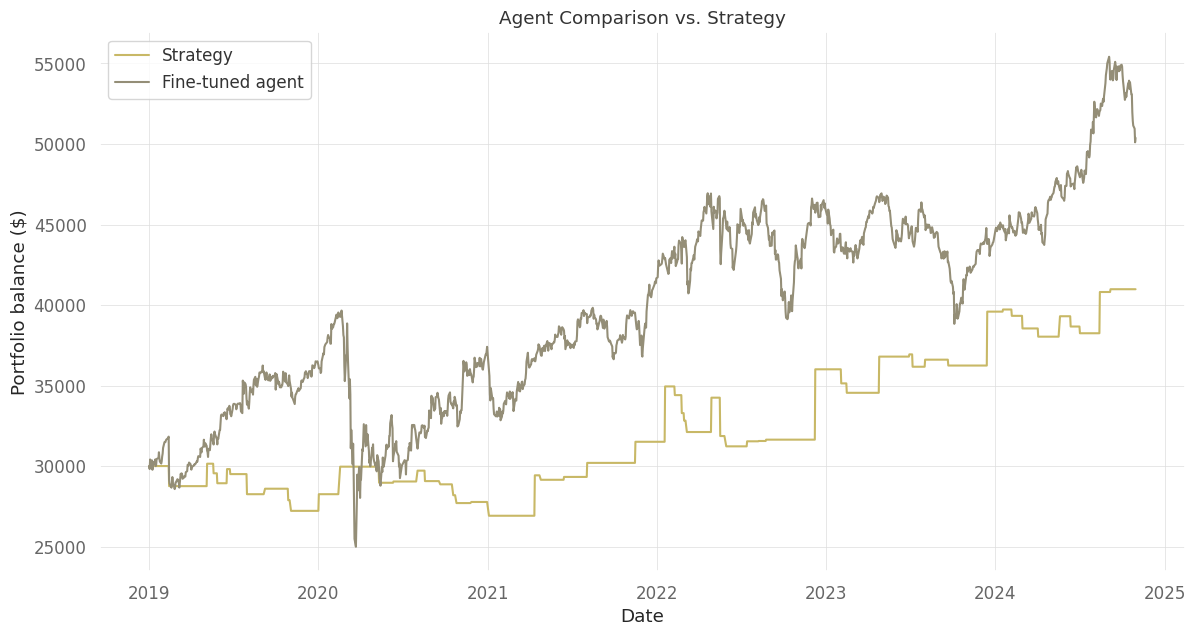

In [16]:
# Plot the portfolio results with cividis color map
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Portfolio'], label='Strategy', color=plt.cm.cividis(0.8))
plt.plot(data.index, ft_portfolio[1:], label='Fine-tuned agent', color=plt.cm.cividis(0.6))
plt.legend()
plt.title('Agent Comparison vs. Strategy')
plt.xlabel('Date')
plt.ylabel('Portfolio balance ($)')
plt.show()